# Spoken Digit Classification
<br/>
<center>Francesco Di Salvo <br/> Politecnico di Torino <br /> s282418@studenti.polito.it</center>
<br />

## Abstract
This document focuses on the Classification model used for predicting Spoken digits recorded in different circumstances. The dataset used contains 2000 spoken digits recorded by four people of numbers from 0 to 9 in English. We had to our proposal 1500 spoken digits for the developement phase, and the remaining 500 for the evalutation phase. Each audio track was recorded with a bit rate of 8KHz and proposed as a '.wav' file. I explored the recordings both in the time and frequency domain, in order to gain more insights and pre process the data in a proper way. For the classification model I used the Random Forest Classifier and I tried to give it pre processed data in both time and frequency domain, and I obtained the best performance by feeding it with Mel-frequency cepstral coefficients (MFFcs) that are derived from a type of cepstral representation of the audio clip. After a proper hyperparameters tuning, I find the best classifier for the predicting model that allow me to perform a 0.996 accuracy. 
    
## Data mining process
The data used for the developement and evaluation phase have a different format. In fact the developement dataset contained the files called with the format "id_label.wav" and of course in the evaluation set we had the format "id.wav". So, in order to manage this difference I developed one single method for the extraction of the information that requires the kind of data needed, with the keywords 'eval' and 'dev'. In order to extract the informations. I used the python's libraries "os" and "scipy". In particular the first one is used for taking the recording names of the current directory, and the second one, thanks to the "wav" module is used for read the audio files. The method wavfile.read() returns in output the sample rate and the samples of the audio track, that is actually the amplitude on each time stamp. After this process I had six objects, two arrays containing the sample rates of the audio signals (eval and dev), two samples of the collections (again eval and dev) and two other array, containing the labels for the developement set, and the indices for the evaluation set. 

In [1]:
import os 
import numpy as np
from scipy.io import wavfile

def get_data(type):
    
    if type not in ['eval','dev']:
        print("-- Parametro non riconosciuto")
        exit(0)
    
    path = '../Datasets/free-spoken-digit/' + type + '/'
    
    audio_files = os.listdir(path)
    
    # we have to initialize them
    # otherwise we cannot have access trough indices
    X = [None for i in range(len(audio_files))]
    y = [None for i in range(len(audio_files))]
    rates = [None for i in range(len(audio_files))]
    
    id_audio = None
    
    for audio_file in audio_files:
        
        """
            eval and dev have two different structures
                dev  : id_label.wav
                eval : id.wav 
        """ 
        
        # id
        if type == "dev":
            id_audio = int(audio_file.split("_")[0])
            y[id_audio] = int(audio_file.split(".")[0].split("_")[1])
        else:
            id_audio = int(audio_file.split(".")[0])
            y[id_audio] = id_audio
        
        complete_path = path + audio_file
        
        rates[id_audio], X[id_audio] = wavfile.read(complete_path)

    return rates, X, y 

In [2]:
Rates_eval, X_eval, ids  = get_data('eval')
Rates_dev,  X_dev, y_dev = get_data('dev')

## Data exploration
The wavfile.read() method returns an integer value and  one array. The first one is the rate of the audio track, and the second one is an array containing samples of the audio signal, so the amplitude spaced evenly in time. 

In [18]:
print("Rates eval :\t", set(Rates_eval))
print("Rates dev  :\t", set(Rates_dev))

Rates eval :	 {8000}
Rates dev  :	 {8000}


So, another important feature is that we're dealing with the same Sample Rates for both evaluation and developement  audio tracks. Now we can also evaluate the mean and the standard deviation about the audios' volume, defined with the well-know formula as follows: 

In [19]:
import math
dbs_dev = [ 20*np.log10(np.sqrt(np.mean(audio**2))) for audio in X_dev if np.mean(audio**2) > 0]
dbs_eval = [ 20*np.log10(np.sqrt(np.mean(audio**2))) for audio in X_eval if np.mean(audio**2) > 0]

print(np.array(dbs_dev).mean(), np.array(dbs_dev).std(), sep="\t")
print(np.array(dbs_eval).mean(), np.array(dbs_eval).std(), sep="\t")

32.35172786014707	2.862332050097958
32.39866107795697	2.9219932739238357


Actually it is not that bad, there is a small standard deviation, so it means that most of the values are close to the mean. 

Now we can start diving into the time domain, and see the variance of the amplitude.

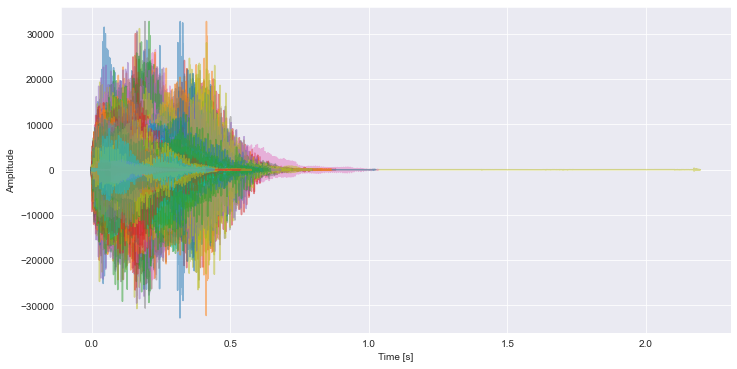

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_amplitude(X):
    sns.set_style("darkgrid")
    plt.figure(figsize=(12,6))

    for i,x in enumerate(X):

        length = x.shape[0] / Rates_dev[i]
        time = np.linspace(0., length, x.shape[0])
        plt.plot(time, x, alpha=0.5)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        
    return plt

plot_amplitude(X_dev).show()

Besides the length of those arrays, we have also a huge variance of amplitude. So as I mentioned before, the best thing to do is to divide those recordings in chunk and just then, we can make some statistical considerations.

## Preprocessing
It can be clearly seen the huge difference among the lengths of those audio tracks, so it could be better to explore their distribution and see what we can do with that.

Text(0.5, 1.0, 'length_eval')

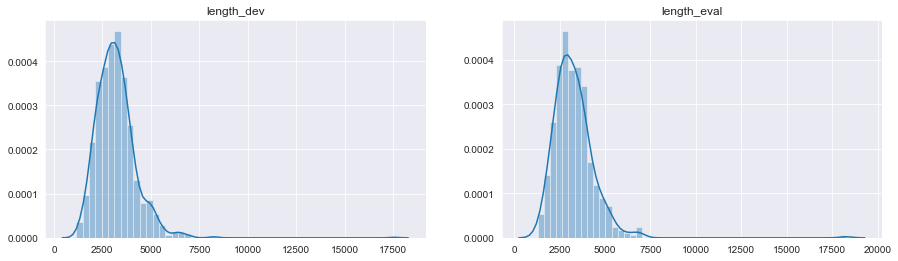

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

lengths_dev = [ len(audio) for audio in X_dev]
lengths_eval = [ len(audio) for audio in X_eval]

fig, ax = plt.subplots(1,2,figsize=(15,4))

sns.distplot(lengths_dev, ax=ax[0])
ax[0].set_title('length_dev')
sns.distplot(lengths_eval, ax=ax[1])
ax[1].set_title('length_eval')

Their distribution is quite similar, but both groups of audio have a wide range of lengths. We could expect that, because some numbers are "longer" than others. The good thing is that most of the audio tracks has approximately the same length, so we can actually "cut" it, in order to have much less attributes. This can improve the score of the model because if we think about the Decision Tree or the Random Forest, they both works way better with less attribues. It is quite important the limit that we choose, and if we see both of them, we could try to cut their length at 6000 digits 

In [83]:
def cut_and_stretch(X, threshold):
    temp =  [ arr if len(arr) <= threshold else arr[:threshold] for arr in X ]
    return  [np.pad(x, (0,thres-len(x)), constant_values=0.0) for x in temp]

def normalize(X):
    return [zscore(arr) for arr in X]

thres = 4000
X_eval_cut = cut_length(X_eval,thres)
X_dev_cut = cut_length(X_dev,thres)

In [75]:
#plot_amplitude(X_dev_cut).show()

FREQUENCY DOMAIN

In [74]:
# stretch all the signals to a fixed length e fillup with 0
#X_dev_cut = [np.pad(x, (0,thres-len(x)), constant_values=0.0) for x in X_dev_cut]
# X_eval_cut = [np.pad(x, (0,thres-len(x)), constant_values=0.0) for x in X_eval_cut]

In [84]:
X_dev_fft = np.fft.fft(X_dev_cut)
X_eval_fft = np.fft.fft(X_eval_cut)

TypeError: only length-1 arrays can be converted to Python scalars

In [37]:
"""def plot_fftV2(ffts, X):
    magnitudes = np.abs(ffts)
    frequencies = np.linspace(0,X,np.max(len(magnitudes)))
    plt.plot(frequencies,magnitudes)
    return plt

plot_fftV2(X_dev_fft, X_dev_cut).show()
"""

'def plot_fftV2(ffts, X):\n    magnitudes = np.abs(ffts)\n    frequencies = np.linspace(0,X,np.max(len(magnitudes)))\n    plt.plot(frequencies,magnitudes)\n    return plt\n\nplot_fftV2(X_dev_fft, X_dev_cut).show()\n'

> Actually, since there is a huge variance among all those signals, it could be useful to normalize them. The aim of normalization is to adjust values measured (or in this case, recorder) on different scales. The two common ways for normalizing data are the "min-max" and "z-score" methods. The first one distributes its values into a range of [0,1], and I don't think this is the perfect scenario to do that. On the other hand, the z-score normalization instead, is defined as:
<br /><br />
<center>$z-score = \frac {X-\mu} {\sigma}$</center>
<br /><br />

> So, the z-score subtracts for each value the mean, and then divide it from the standard deviation. We could do tha with scipy.stats.zscore that needs the array that we want to normalize, and returns the normalized array. 

In [66]:
from scipy.stats import zscore


#X_dev_norm = normalize(X_dev_cut)
#X_eval_norm = normalize(X_eval_cut)

In [67]:
X_dev_norm = normalize(np.real(X_dev_fft))
X_eval_norm = normalize(np.real(X_eval_fft))

In [73]:
# plot_amplitude(X_dev_norm).show()

>Now it is much more regular than before. 

> Once we normalize the audio tracks we should start to make some "statistical" measure on some audio chunks, as the instructors suggested. In order to split our set into several chunks, we have to consider our Sample Rate, that is 8000 for each one. The sample rate tell us that we need 8000 elements of our array in order to have 1 second. It is quite important to choose a proper length for each chunk, because a little chuck may not add any particular information, and a larger one may generalize too much that signal. Since most of the amplitudes are concentrated in the first 0.8 seconds, we could try to split each second into 10 chunks. 

## Classification model
Now let's start with the magic, we'll try different classifiers with different hyperparameters, in order to choose the best one. The first one will be the Random Forest Classsifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

def get_classifier(X_train, X_test, y_train, y_test, param_grid):
    
    clf_init = RandomForestClassifier()
    clf = GridSearchCV(clf_init, param_grid, cv=3, scoring='f1_macro', n_jobs=4)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    return clf

In [70]:
from sklearn.model_selection import train_test_split
import pandas as pd

# hyperparams for the Grid Search
n_estimators = [500, 1000, 2000]
max_depth = [100, 200, 250]

params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [76]:
#clf_final = get_classifier(X_train, X_test, y_train, y_test, params_grid)

In [77]:
#clf_final.fit(X_train,y_train)
#print(classification_report(y_test,clf_final.predict(X_test)))

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_dev_norm,y_dev, test_size=0.20, stratify=y_dev)

c = RandomForestClassifier(max_depth=200, n_estimators=2000, verbose=True, n_jobs=4)
c.fit(X_train,y_train)
y_pred_2 = c.predict(X_test)
print(classification_report(y_test,y_pred_2))

ValueError: setting an array element with a sequence.

## Setup the output file
In order to the online evaluation we have to generate a csv file containing the ID of the audio track and the predicted value, respectively. 

In [41]:
def get_csv(ids, y):
    pd.DataFrame(dict( 
                   Id = ids,
                   Predicted = y
           )).to_csv("submission.csv",sep=",",index=False)

In [58]:
#get_csv(ids,y_pred)